# Exploratory Data Analysis

In [255]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt/concrete",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush/shrub",
        "fence",
        "other-structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0  , 0  , 0  ),
        (230, 25 , 75 ),
        (60 , 180, 75 ),
        (255, 225, 25 ),
        (0  , 130, 200),
        (145, 30 , 180),
        (70 , 240, 240),
        (240, 50 , 230),
        (210, 245, 60 ),
        (250, 190, 190),
        (0  , 128, 128),
        (170, 110, 40 ),
        (255, 250, 200),
        (128, 0  , 0  ),
        (170, 255, 195),
        (128, 128, 0  ),
        (255, 215, 180),
        (0  , 0  , 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

In [257]:
def load_and_sample_data(file_path=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

PATH = ''
def get_dfs():
    train_df = pd.read_csv(PATH + 'train.csv')
    val_df   = pd.read_csv(PATH + 'val.csv'  )
    test_df  = pd.read_csv(PATH + 'test.csv' )
    return (train_df, val_df, test_df)

train_df, val_df, test_df = get_dfs()

In [2]:
import os
BIN_PATH = 'bin/'
if not os.path.exists(BIN_PATH):
    os.makedirs(BIN_PATH)

# 1. Basic Analyses

### 1.1. Invalid value check

In [412]:
def print_invalid_summary(df, invalid_type, set_name):
    if invalid_type == "null":
        df_check = df.isnull()
    elif invalid_type == "nan":
        df_check = df.isna()
    else:
        df_check = (df == '')
        invalid_type = "empty entry"
    print(f'{set_name.capitalize()} set {invalid_type} summary')
    print(df_check.sum())
    print()

print_invalid_summary(train_df, "null", "train")
print_invalid_summary(val_df  , "null", "val"  )
print_invalid_summary(test_df , "null", "test" )

Train set null summary
id            0
im_path       0
label_path    0
dtype: int64

Val set null summary
id            0
im_path       0
label_path    0
dtype: int64

Test set null summary
id            0
im_path       0
label_path    0
dtype: int64



In [410]:
print_invalid_summary(train_df, "nan", "train")
print_invalid_summary(val_df  , "nan", "val"  )
print_invalid_summary(test_df , "nan", "test" )

Train set nan summary
id            0
im_path       0
label_path    0
dtype: int64

Val set nan summary
id            0
im_path       0
label_path    0
dtype: int64

Test set nan summary
id            0
im_path       0
label_path    0
dtype: int64



In [411]:
print_invalid_summary(train_df, "", "train")
print_invalid_summary(val_df  , "", "val"  )
print_invalid_summary(test_df , "", "test" )

Train set empty entry summary
id            0
im_path       0
label_path    0
dtype: int64

Val set empty entry summary
id            0
im_path       0
label_path    0
dtype: int64

Test set empty entry summary
id            0
im_path       0
label_path    0
dtype: int64



### 1.2. Invalid file directory check

In [379]:
def file_exist(file_paths):
    for fp in file_paths:
        directory = os.path.dirname(fp)
        if not os.path.exists(directory):
            return False
    return True

def df_check_file_exist(df):
    im_path = np.array(df['im_path'])
    label_path = np.array(df['label_path'])
    return file_exist(im_path) and file_exist(label_path)

def id_matching(df):
    # check whether id matches im_path and label_path file names
    paths_lst = [
        np.array(df['id']), np.array(df['im_path']), np.array(df['label_path'])
    ]
    filenames = [None] * len(paths_lst)
    extract_subdirectory = np.vectorize(
        lambda paths, delim: np.char.split(paths, delim)
    )
    remove_extension = np.vectorize(
        lambda fn: fn[:fn.rfind('.')] if '.' in fn else fn
    )
    for i, paths in enumerate(paths_lst):
        split_paths  = extract_subdirectory(paths, '/')
        fn = np.array([path.tolist()[-1] for path in split_paths])
        fn = remove_extension(fn)
        filenames[i] = fn
    filenames = np.array(filenames)
    match_arr = (filenames == filenames[0]).all(axis=0)
    return np.all(match_arr)

#### File directory existence check

In [370]:
print(f'All file directories exist in Train: {df_check_file_exist(train_df)}')
print(f'All file directories exist in Val  : {df_check_file_exist(val_df  )}')
print(f'All file directories exist in Test : {df_check_file_exist(test_df )}')

All file directories exist in Train: True
All file directories exist in Val  : True
All file directories exist in Test : True


#### ID matching check

In [380]:
print(f'All IDs are matched in Train: {id_matching(train_df)}')
print(f'All IDs are matched in Val  : {id_matching(val_df  )}')
print(f'All IDs are matched in Test : {id_matching(test_df )}')

All IDs are matched in Train: True
All IDs are matched in Val  : True
All IDs are matched in Test : True


### 1.3. Duplicates check

Another thing we could perhaps check is whether if there are any duplicated **images**.

In [384]:
print(f'Duplicate count of train set: {train_df.duplicated().sum()}')
print(f'Duplicate count of val   set: {val_df  .duplicated().sum()}')
print(f'Duplicate count of test  set: {test_df .duplicated().sum()}')

Duplicate count of train set: 0
Duplicate count of val   set: 0
Duplicate count of test  set: 0


### 1.4. Data Leakage

#### **Entry leakage check**

Since we have verified that all IDs matched up, all we need to do is compare the IDs of 1 dataset against the other.

In [396]:
def entry_unique(df1, df2):
    ids1 = np.array(df1['id'])
    ids2 = np.array(df2['id'])
    return len(np.intersect1d(ids1, ids2))

print(f'Train and Test has {entry_unique(train_df, test_df)} shared entries')
print(f'Train and Val  has {entry_unique(train_df, val_df )} shared entries')
print(f'Test  and Val  has {entry_unique(test_df , val_df )} shared entries')

Train and Test has 0 shared entries
Train and Val  has 0 shared entries
Test  and Val  has 0 shared entries


#### **Image leakage check**

Another thing we must check is whether if there are any duplicated **images** across datasets. Furthermore, we should calculate the correlation between every pair of every image from different datasets. If there are many highly-correlated images in the dataset, the leakage issue must be appropriately addressed.

In [407]:
def compute_dataset_correlation(df1, df2, col='im_path', threshold=0.85):
    im_paths1 = np.array(df1[col])
    im_paths2 = np.array(df2[col])
    scores = np.zeros((im_paths1.shape[0], 2))
    for i, ip1 in enumerate(im_paths1):
        corrs = np.zeros((im_paths2.shape[0],))
        for j, ip2 in enumerate(im_paths2):
            img1 = cv2.imread(ip1)
            img2 = cv2.imread(ip2)
            img1 = img1.flatten()
            img2 = img2.flatten()
            corr = np.corrcoef(img1, img2)[0, 1]
            corrs[j] = corr
        # threshold shows at which point correlation is considered large
        scores[i] = np.array([
            np.max(corrs), len(corrs[corrs > threshold])
        ])
    return scores

def print_correlations(scores, df1_name, df2_name, threshold):
    df1_name     = df1_name.capitalize()
    df2_name     = df2_name.capitalize()
    max_scores   = scores[:,0]
    total_exceed = np.sum(scores[:,1])
    mean_max     = np.mean(max_scores)
    med_max      = np.median(max_scores)
    max_score    = np.max(max_scores)
    title        = f'Summary of correlation between {df1_name} and {df2_name}'
    print(f'{title}\n{'-'*len(title)}')
    print(f'Total number of correlations exceeding {threshold}: {total_exceed}')
    print(f'Mean of all maximum pairwise correlations: {mean_max}')
    print(f'Median of all maximum pairwise correlations: {med_max}')
    print(f'Maximum of all maximum pairwise correlations: {max_score}')

#### Correlation summary between Test and Train

In [ ]:
corr_threshold = 0.85
corr_train_test = compute_dataset_correlation(train_df, test_df, threshold=corr_threshold)
print_correlations(corr_train_test, "train", "test", corr_threshold)

#### Correlation summary between Val and Train

In [ ]:
corr_val_test = compute_dataset_correlation(val_df, test_df, threshold=corr_threshold)
print_correlations(corr_val_test, "val", "test", corr_threshold)

# 2. Distribution Analysis

### Plotting helpers

In [201]:
def plot_distribution(distribution, title, classes, log=True, save=True):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(distribution)), distribution, tick_label=[
        f'{classes[i]}' for i in range(len(distribution))
    ])
    plt.title(title)
    plt.xticks(rotation=75)
    y_label = 'Frequency (log scale)'
    if log:
        y_label = 'Frequency'
    if save:
        plt.savefig(BIN_PATH + title)
    plt.xlabel('Class')
    plt.ylabel(y_label)
    plt.show()


def plot_multiple_distributions(
    folder_labels, title, subtitles, labels,
    log=True, x_axis_factor=None, y_axis_factor=1, font_factor=1,
    sharey=False, save=True
):
    # row, column, and factoring
    total = len(folder_labels)
    cols  = 2
    rows  = total//cols + 1 if total > cols else 1
    if x_axis_factor is None:
        x_axis_factor = 2.2 if rows == 1 else 1.2*(rows-1)

    # figure and axis
    fig, ax = plt.subplots(
        rows, cols, figsize=(15*x_axis_factor, 15*y_axis_factor), sharey=sharey
    )
    title = f'{title} (log-scaled)' if log else title
    fig.suptitle(title, fontsize=25*font_factor)
    y_label = 'Frequency (log scale)' if log else 'Frequency'
    fig.text(0.5, 0.04, 'Class', ha='center', fontsize=15)
    fig.text(0.06, 0.5, y_label, va='center', rotation='vertical', fontsize=15)

    # legend
    legend_labels  = [f'{i}: {labels[i]}' for i in range(len(labels))]
    legend_handles = [plt.Rectangle((0,0), 0, 0, alpha=0.0) for _ in labels]
    fig.legend(
        legend_handles, legend_labels, loc='lower right', prop={'size': 12}
    )

    # distribution for each folder
    for i in range(cols*rows):
        ax_i = ax[i] if rows == 1 else ax[i//cols, i%cols]
        if i >= total:
            ax_i.axis('off')
            continue # leave blank rather than stop
        distribution = folder_labels[i]
        ax_i.bar(range(len(distribution)), distribution, tick_label=[
            f'{i}' for i in range(len(distribution))
        ])
        if log and np.any(distribution != 0):
            ax_i.set_yscale('log')
        ax_i.set_title(subtitles[i], fontsize=17*font_factor)

    if save:
        fig.savefig(BIN_PATH + title)

### Label distribution helpers

In [4]:
def label_arr(df):
    return np.array(df['label_path'])

def label_distributions(classes, path=None, arr=None):
    assert not path is None or not arr is None
    n = len(classes)
    labels = np.zeros((n,))
    if type(arr) != np.ndarray:
        arr = np.array(arr)
    paths = arr if path is None else os.listdir(path)
    for i, label_path in enumerate(paths):
        label = cv2.imread(label_path, -1)
        labels += np.bincount(label.flatten(), minlength=n)
    return labels


# Specific to folder distribution
def filter_by_subdirectories(paths, subdirectories, indx=1, delim='/'):
    ret = [None] * len(subdirectories)
    extract_subdirectory = np.vectorize(
        lambda paths, delim: np.char.split(paths, delim)
    )
    split_paths = extract_subdirectory(paths, delim)
    subdir_arr  = np.array([path.tolist()[indx] for path in split_paths])
    for i, subdirectory in enumerate(subdirectories):
        ret[i] = paths[subdir_arr == subdirectory]
    return ret

## 2.1. Global distributions

In [5]:
val_labels     = label_distributions(METAINFO['classes'], arr=label_arr(val_df  ))
train_labels   = label_distributions(METAINFO['classes'], arr=label_arr(train_df))
test_labels    = label_distributions(METAINFO['classes'], arr=label_arr(test_df ))
dataset_labels = val_labels + train_labels + test_labels

### **Training label distribution**

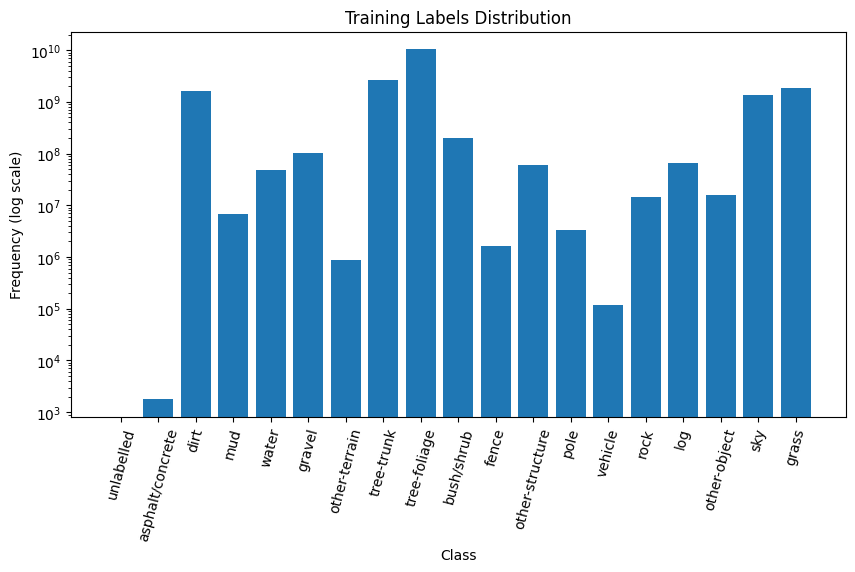

In [6]:
plot_distribution(train_labels, 'Training Labels Distribution', METAINFO['classes'])

### **Validating label distribution**

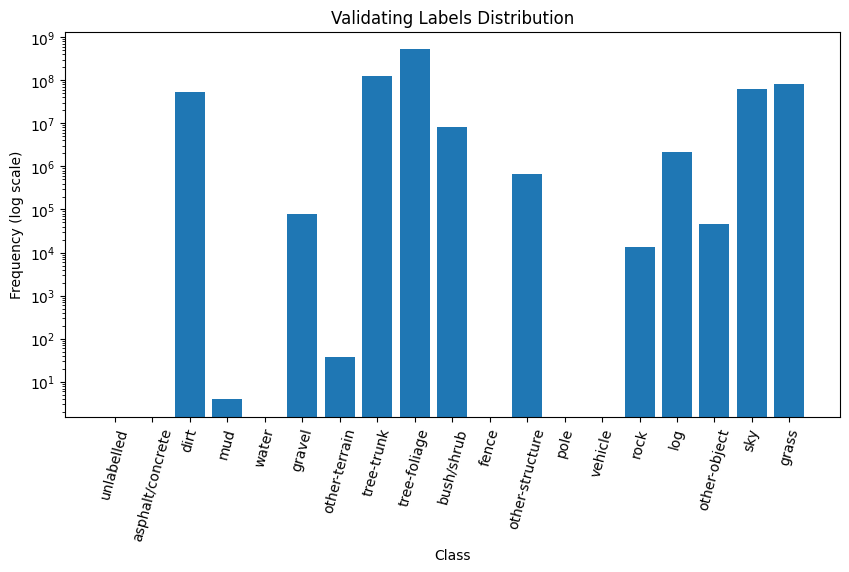

In [7]:
plot_distribution(val_labels, 'Validating Labels Distribution', METAINFO['classes'])

### **Testing label distribution**

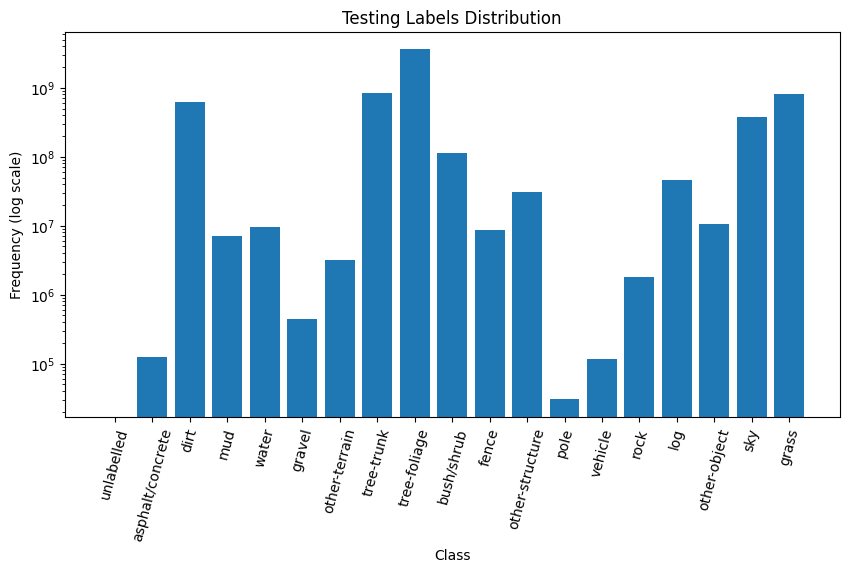

In [8]:
plot_distribution(test_labels, 'Testing Labels Distribution', METAINFO['classes'])

### **Dataset label distribution**

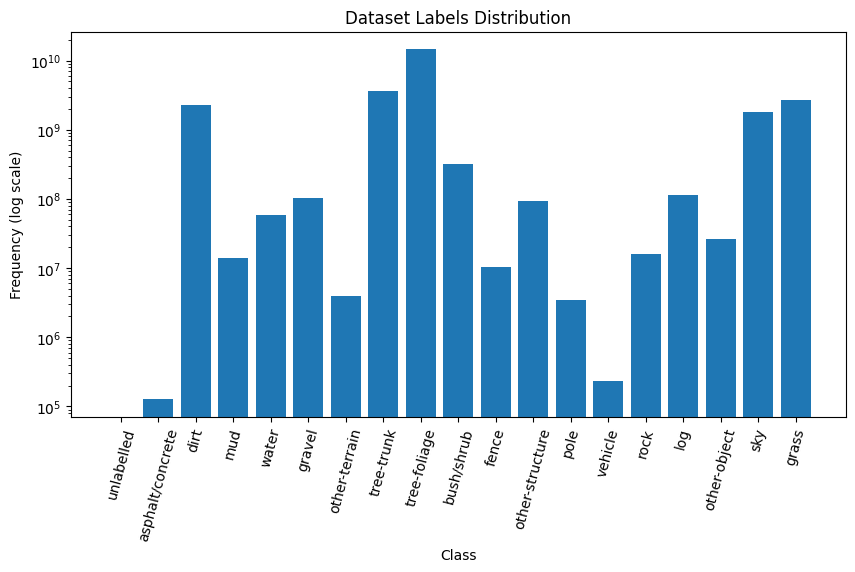

In [9]:
plot_distribution(dataset_labels, 'Dataset Labels Distribution', METAINFO['classes'])

### Commentary

Should be on how the split retains the dataset distribution among each subset (and possibly that it is indeed random, if it can even be proven - or at least a split process should be cited), especially train - since retaining distribution in train meant that the training data is most representative of the original data. Testing set retaining the distribution is also important, since it meant the performance evaluation is also the most representative.

## 2.2. Folder distributions

In [10]:
def get_folder_labels(folders):
    folder_labels = [None] * len(folders)
    for i, folder in enumerate(folders):
        folder_labels[i] = label_distributions(METAINFO['classes'], arr=folder)
    return folder_labels

In [11]:
subdirectories = ['K-01', 'K-03', 'V-01', 'V-02', 'V-03']
train_folders = filter_by_subdirectories(np.array(train_df['label_path']), subdirectories)
val_folders   = filter_by_subdirectories(np.array(val_df  ['label_path']), subdirectories)
test_folders  = filter_by_subdirectories(np.array(test_df ['label_path']), subdirectories)

train_folder_labels = get_folder_labels(train_folders)
val_folder_labels   = get_folder_labels(val_folders  )
test_folder_labels  = get_folder_labels(test_folders )

id_labels = {i: e for i, e in enumerate(METAINFO['classes'])}

### **Training distribution by folder**

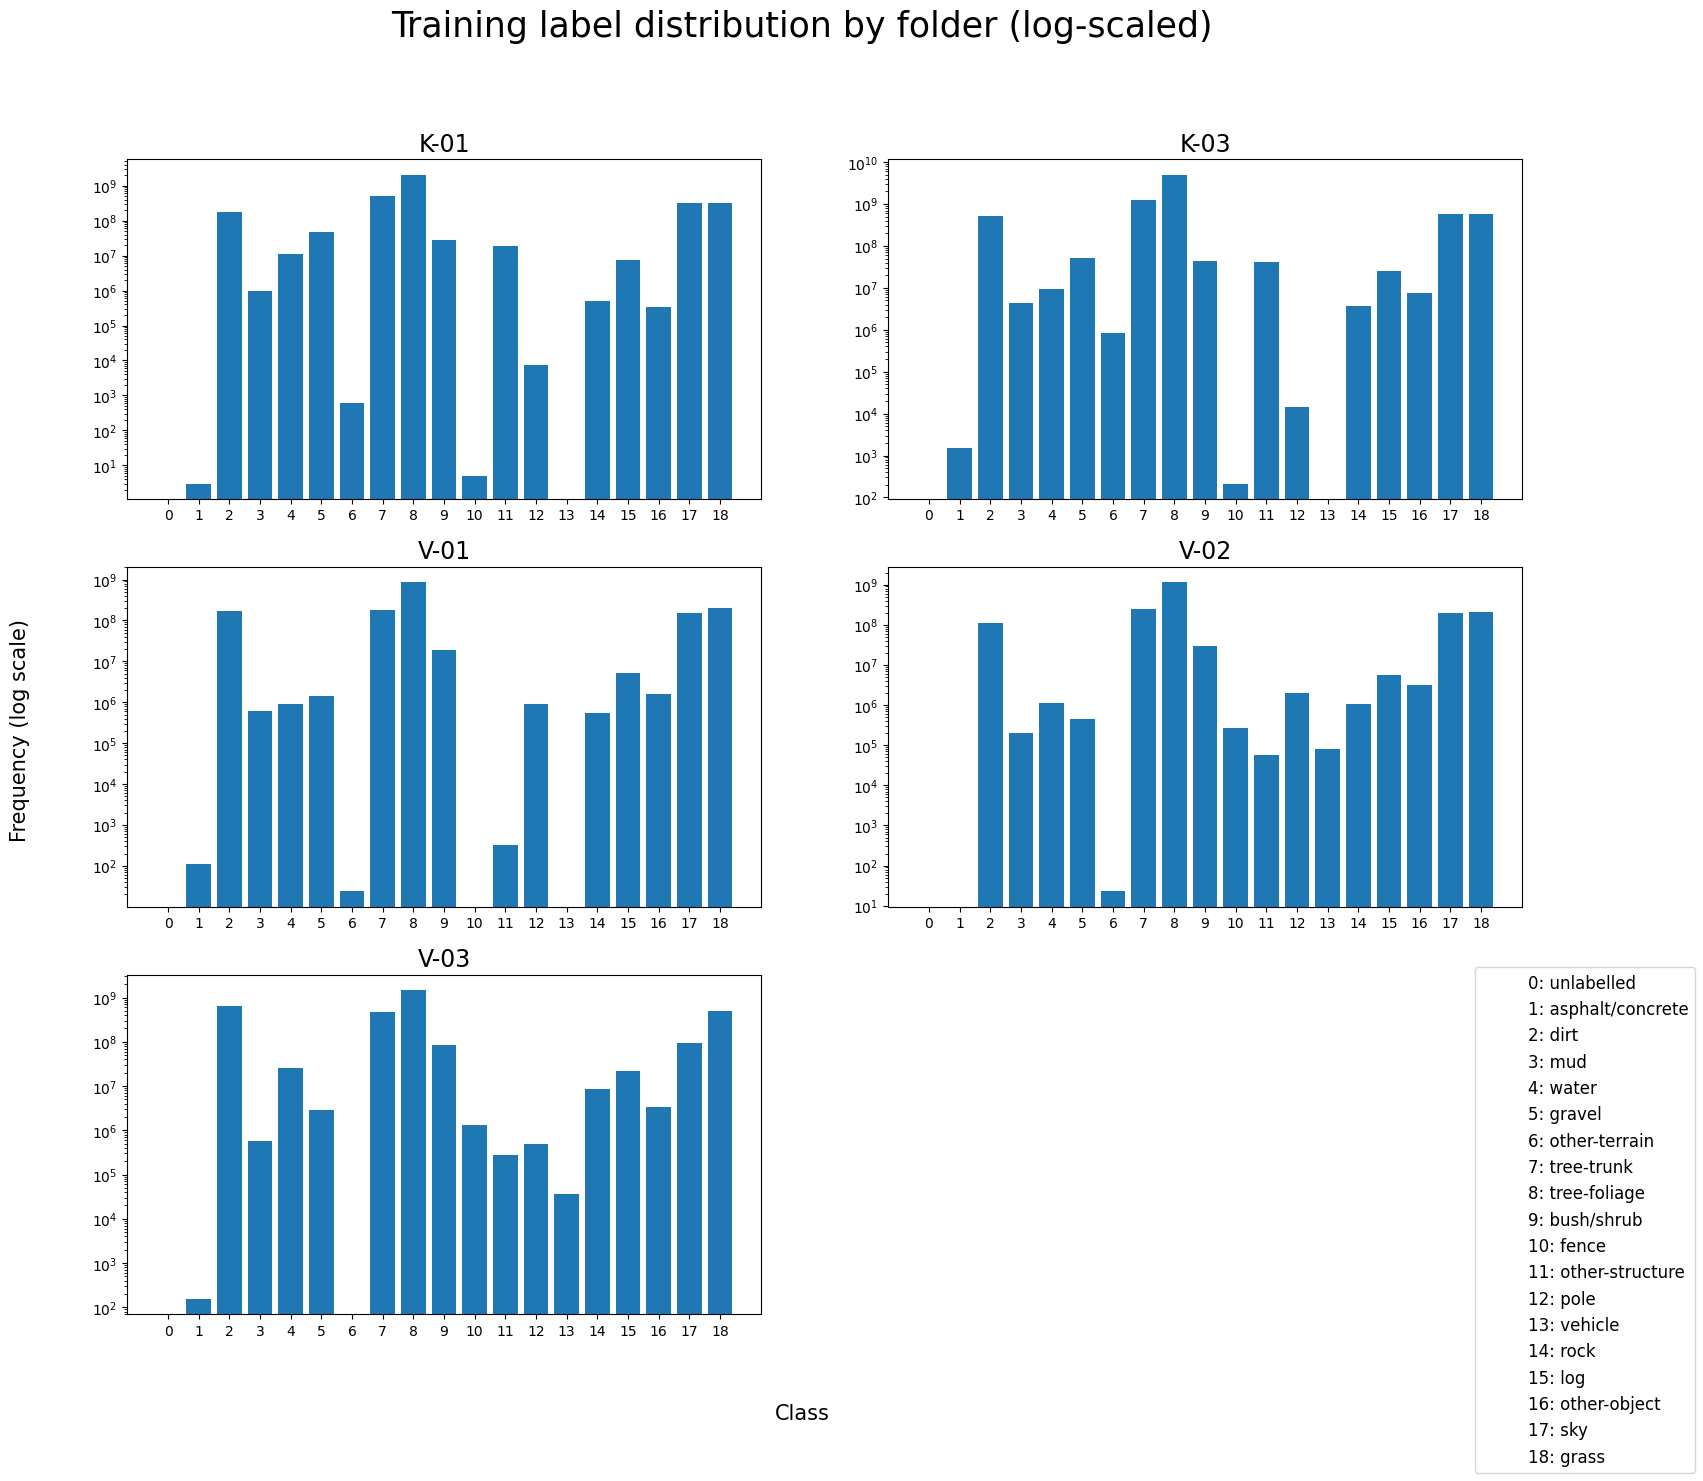

In [198]:
plot_multiple_distributions(
    train_folder_labels,
    "Training label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    x_axis_factor=1.2,
)

### **Validating distribution by folder**

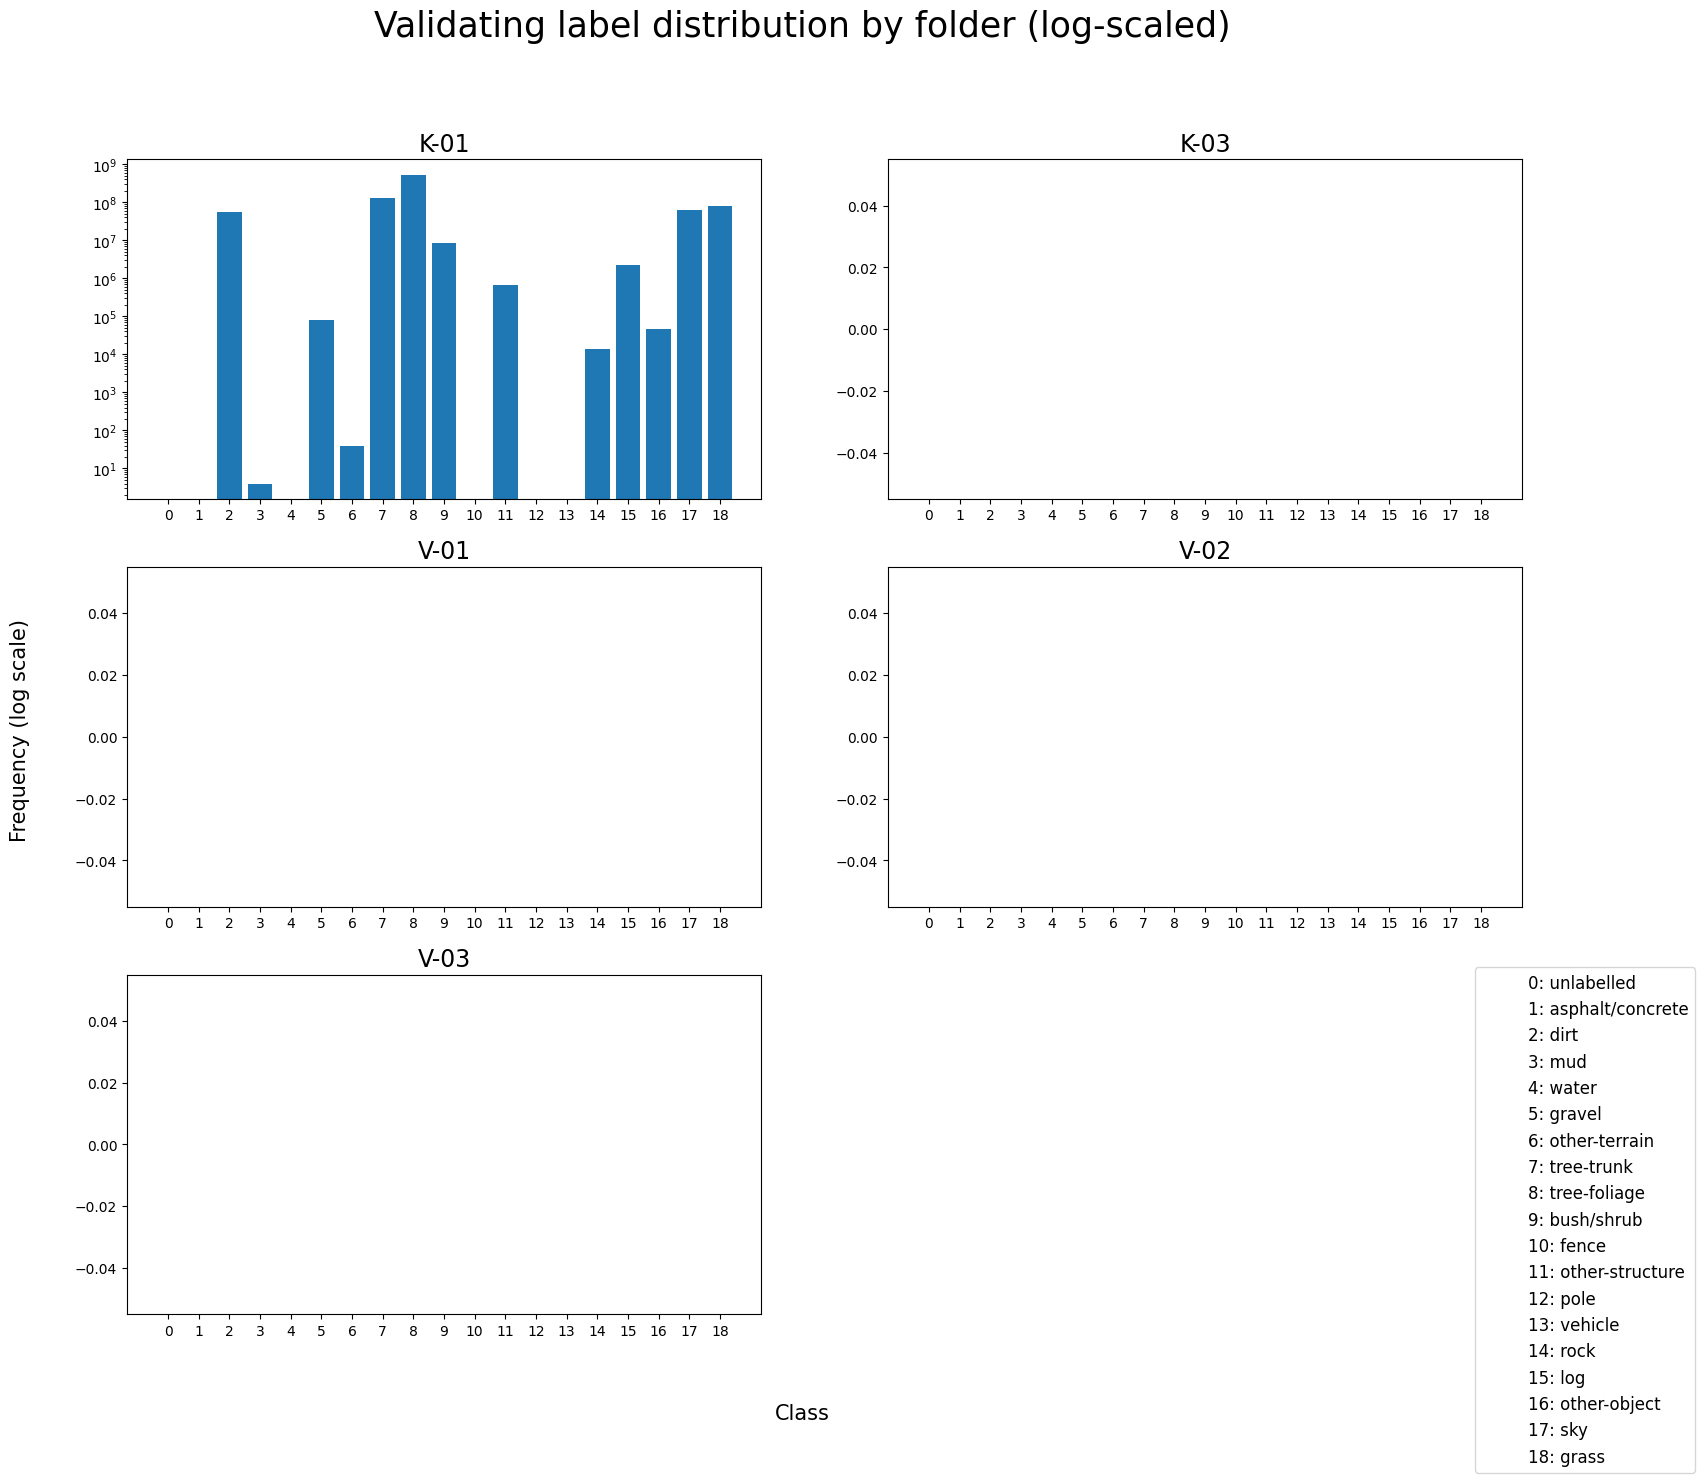

In [199]:
plot_multiple_distributions(
    val_folder_labels,
    "Validating label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    x_axis_factor=1.2,
)

### **Testing distribution by folder**

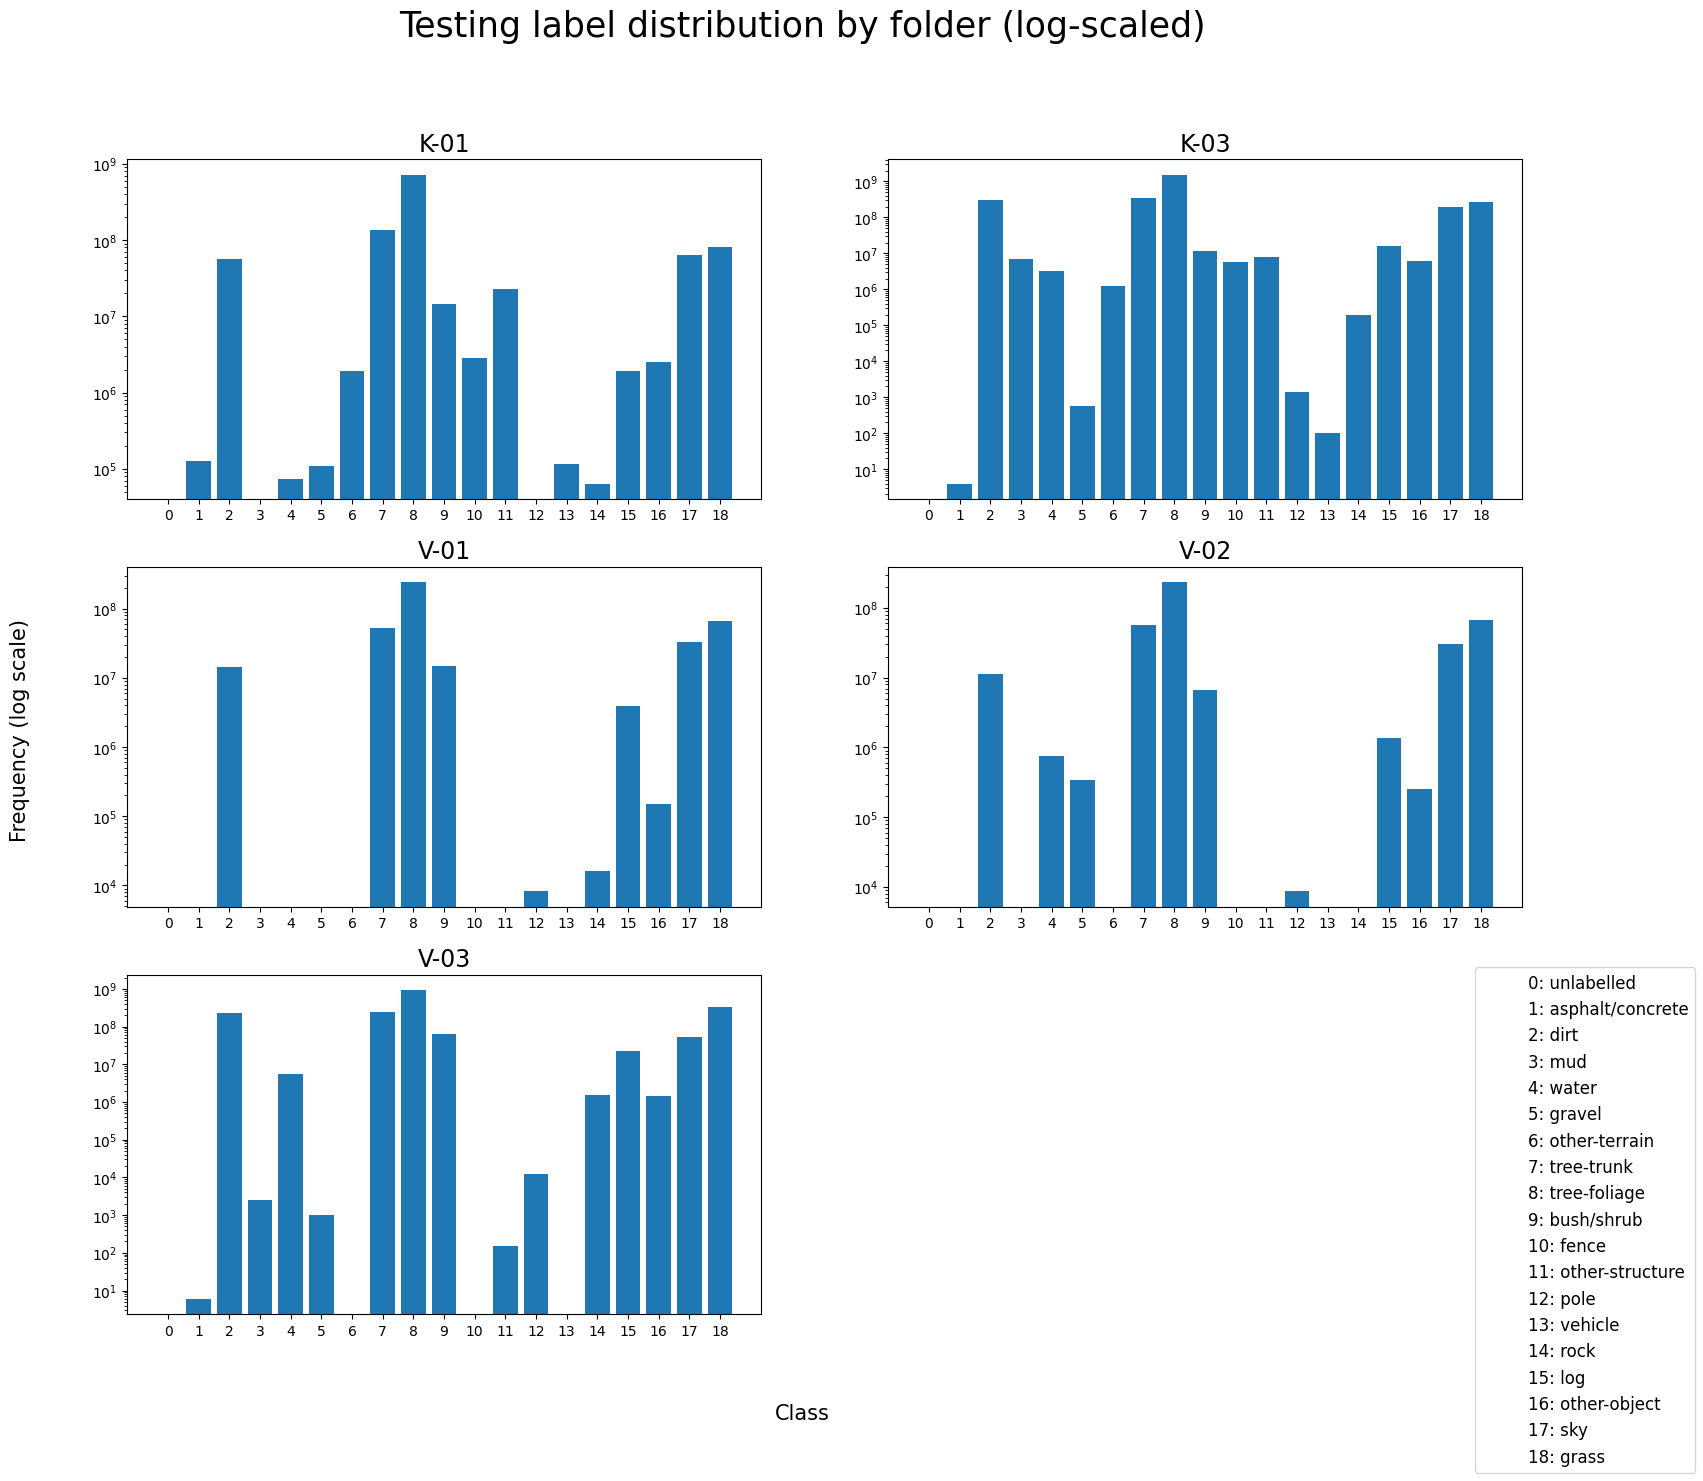

In [200]:
plot_multiple_distributions(
    test_folder_labels,
    "Testing label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    x_axis_factor=1.2,
)

# 3. Sampling

### Stratified Sampling based on label distribution

In [441]:
def stratified_sampling(
    counts_array, # array storing label counts of each image in dataset
    total_counts, # array storing dataset's label count
    sample_frac,  # sample size fraction
    seed=100,     # random seed
    t=0.05,       # threshold to ignore split
):
    """
    Stratified sampling based on label count algorithm:
    For threshold argument t:
        if #label with min count < 0.05 #label with second least count
        we do not sample with fraction for said min label
    """
    sample_size = int(len(counts_array) * sample_frac)
    np.random.seed(seed)

    # calculate the proportion of each label for sample's desired label count
    total_labels = np.sum(total_counts)
    label_proportions = total_counts / total_labels
    desired_label_counts = (label_proportions * sample_size).astype(int)
    
    # ignore splitting labels that are too little in size
    argsort = np.argsort(total_counts)
    min_indx = 0
    while argsort[min_indx] == 0:
        min_indx += 1
        if min_indx >= len(argsort) - 1:
            break
    if argsort[min_indx+1] == 0 or \
        total_counts[argsort[min_indx]] / total_counts[argsort[min_indx+1]] >= t:
        min_indx = 0
    selected_indices = []

    # for each label
    for i in range(counts_array.shape[1]):
        # indices of samples containing the label
        label_indices = np.where(counts_array[:, i] > 0)[0]

        # randomly sample (without replacement) instead
        selected = np.random.choice(label_indices, size=desired_label_counts[i], replace=False)\
            if i != min_indx else label_indices
        selected_indices.extend(selected)

    # Remove duplicates
    selected_indices = list(set(selected_indices))
    
    # ensuring the desired number of samples
    if len(selected_indices) > sample_size:
        selected_indices = selected_indices[:sample_size]
    elif len(selected_indices) < sample_size:
        remaining_indices = list(set(range(len(counts_array))) - set(selected_indices))
        np.random.shuffle(remaining_indices)
        selected_indices.extend(remaining_indices[:sample_size - len(selected_indices)])
    return selected_indices

### Additional helpers

In [444]:
def get_y(arr):
    y = [None] * len(arr)
    if type(arr) != np.ndarray:
        arr = np.array(arr)
    for i, label_path in enumerate(arr):
        label = cv2.imread(label_path, -1)
        y[i]  = np.bincount(label.flatten(), minlength=NUM_CLASSES)
    return y


def print_sampling_labelwise_info(
    labels, labels_sampled, label_dict, frac=0.5
):
    title = f'\t\t Original \tSampled \tProportion'
    print('-'*(len(title.replace('\t', ' '*8))-2))
    print(title)
    set_tab = lambda s: '\t' if len(f'{s}') >= 8 else '\t\t'
    rnd = lambda n: round(n, 2)
    for i, label in label_dict.items():
        tabs = '\t\t ' if len(label) < 10 else '\t '
        if len(label) >= 16:
            tabs = ' '
        l  = rnd(labels[i])
        ls = rnd(labels_sampled[i])
        f  = rnd(ls/l) if l != 0 else 0
        l_tabs  = set_tab(l )
        ls_tabs = set_tab(ls)
        print(f'{label}{tabs}{l}{l_tabs}{ls}{ls_tabs}{f}')
    l_sum   = rnd(np.sum(labels))
    ls_sum  = rnd(np.sum(labels_sampled))
    l_tabs  = set_tab(l_sum )
    ls_tabs = set_tab(ls_sum)
    print(f'Total\t\t {l_sum}{l_tabs}{ls_sum}{ls_tabs}{rnd(ls_sum/l_sum)}')


def print_sampling_info(labels, labels_sampled, set_name, label_dict, frac=0.5):
    title = (
        f'{set_name.capitalize()} label distribution between Original and Sampled '
        f'(frac = {frac})'
    )
    print(title)
    print('=' * len(title))
    print("\nNormal-scaled")
    print_sampling_labelwise_info(labels, labels_sampled, label_dict, frac)
    print("\nLog-scaled")
    print_sampling_labelwise_info(
        np.log1p(labels), np.log1p(labels_sampled), label_dict, frac
    )


def no_duplicates(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return len(unique[counts > 1]) == 0


# The purpose is just to not store huge arrays, and instead remove them
# as soon as function terminates
def get_labels_sampled(df, distribution, col='label_path', frac=0.5, seed=100):
    y = get_y(df[col])
    y = np.array(y)
    sampled_indx = stratified_sampling(y, distribution, frac, seed=seed)
    assert no_duplicates(sampled_indx)
    sampled_data = label_arr(df)[sampled_indx]
    sample_dist = label_distributions(METAINFO['classes'], arr=sampled_data)
    return sample_dist, sampled_indx

In [452]:
def get_labels_sampled2(df, distribution, y, col='label_path', frac=0.5, seed=5):
    # y = get_y(df[col])
    # y = np.array(y)
    sampled_indx = stratified_sampling(y, distribution, frac, seed=seed)
    assert no_duplicates(sampled_indx)
    sampled_data = label_arr(df)[sampled_indx]
    sample_dist = label_distributions(METAINFO['classes'], arr=sampled_data)
    return sample_dist, sampled_indx


train_labels_sampled2, train_indx_sampled2 = get_labels_sampled2(
    train_df, train_labels, np.array(y)
)

In [453]:
print_sampling_info(train_labels, train_labels_sampled2, "train", id_labels)

Train label distribution between Original and Sampled (frac = 0.5)

Normal-scaled
----------------------------------------------------------
		 Original 	Sampled 	Proportion
unlabelled	 0.0		0.0		0
asphalt/concrete 1794.0		1794.0		1.0
dirt		 1600840094.0	818554872.0	0.51
mud		 6857813.0	3343521.0	0.49
water		 48116742.0	25238762.0	0.52
gravel		 103405446.0	49677254.0	0.48
other-terrain	 860988.0	413572.0	0.48
tree-trunk	 2639454701.0	1308147097.0	0.5
tree-foliage	 10507673624.0	5224512509.0	0.5
bush/shrub	 203633644.0	105305092.0	0.52
fence		 1620768.0	882559.0	0.54
other-structure	 60550301.0	27658051.0	0.46
pole		 3377421.0	1596758.0	0.47
vehicle		 118755.0	74996.0		0.63
rock		 14315444.0	7242737.0	0.51
log		 65429710.0	32548243.0	0.5
other-object	 15645583.0	7202479.0	0.46
sky		 1350206976.0	682663290.0	0.51
grass		 1822499988.0	925717214.0	0.51
Total		 18444609792.0	9220780800.0	0.5

Log-scaled
----------------------------------------------------------
		 Original 	Sampled 	Proport

### **Global Stratified Sampled Training**

In [442]:
train_labels_sampled, train_indx_sampled = get_labels_sampled(
    train_df, train_labels, frac=0.5, seed=100
)
print_sampling_info(train_labels, train_labels_sampled, "train", id_labels)

Train label distribution between Original and Sampled (frac = 0.5)

Normal-scaled
------------------------------------------------------------
		 Original 	Sampled 	Proportion
unlabelled	 0.0		0.0		0
asphalt/concrete 1794.0		1794.0		1.0
dirt		 1600840094.0	806971130.0	0.5
mud		 6857813.0	3953445.0	0.58
water		 48116742.0	23239516.0	0.48
gravel		 103405446.0	56097430.0	0.54
other-terrain	 860988.0	459272.0	0.53
tree-trunk	 2639454701.0	1297931347.0	0.49
tree-foliage	 10507673624.0	5226293688.0	0.5
bush/shrub	 203633644.0	102049361.0	0.5
fence		 1620768.0	841293.0	0.52
other-structure	 60550301.0	29303642.0	0.48
pole		 3377421.0	1771094.0	0.52
vehicle		 118755.0	47312.0		0.4
rock		 14315444.0	8562732.0	0.6
log		 65429710.0	29997040.0	0.46
other-object	 15645583.0	7969719.0	0.51
sky		 1350206976.0	686727803.0	0.51
grass		 1822499988.0	938563182.0	0.51
Total		 18444609792.0	9220780800.0	0.5

Log-scaled
------------------------------------------------------------
		 Original 	Sampled 	Propo

### Log-scaled comparison

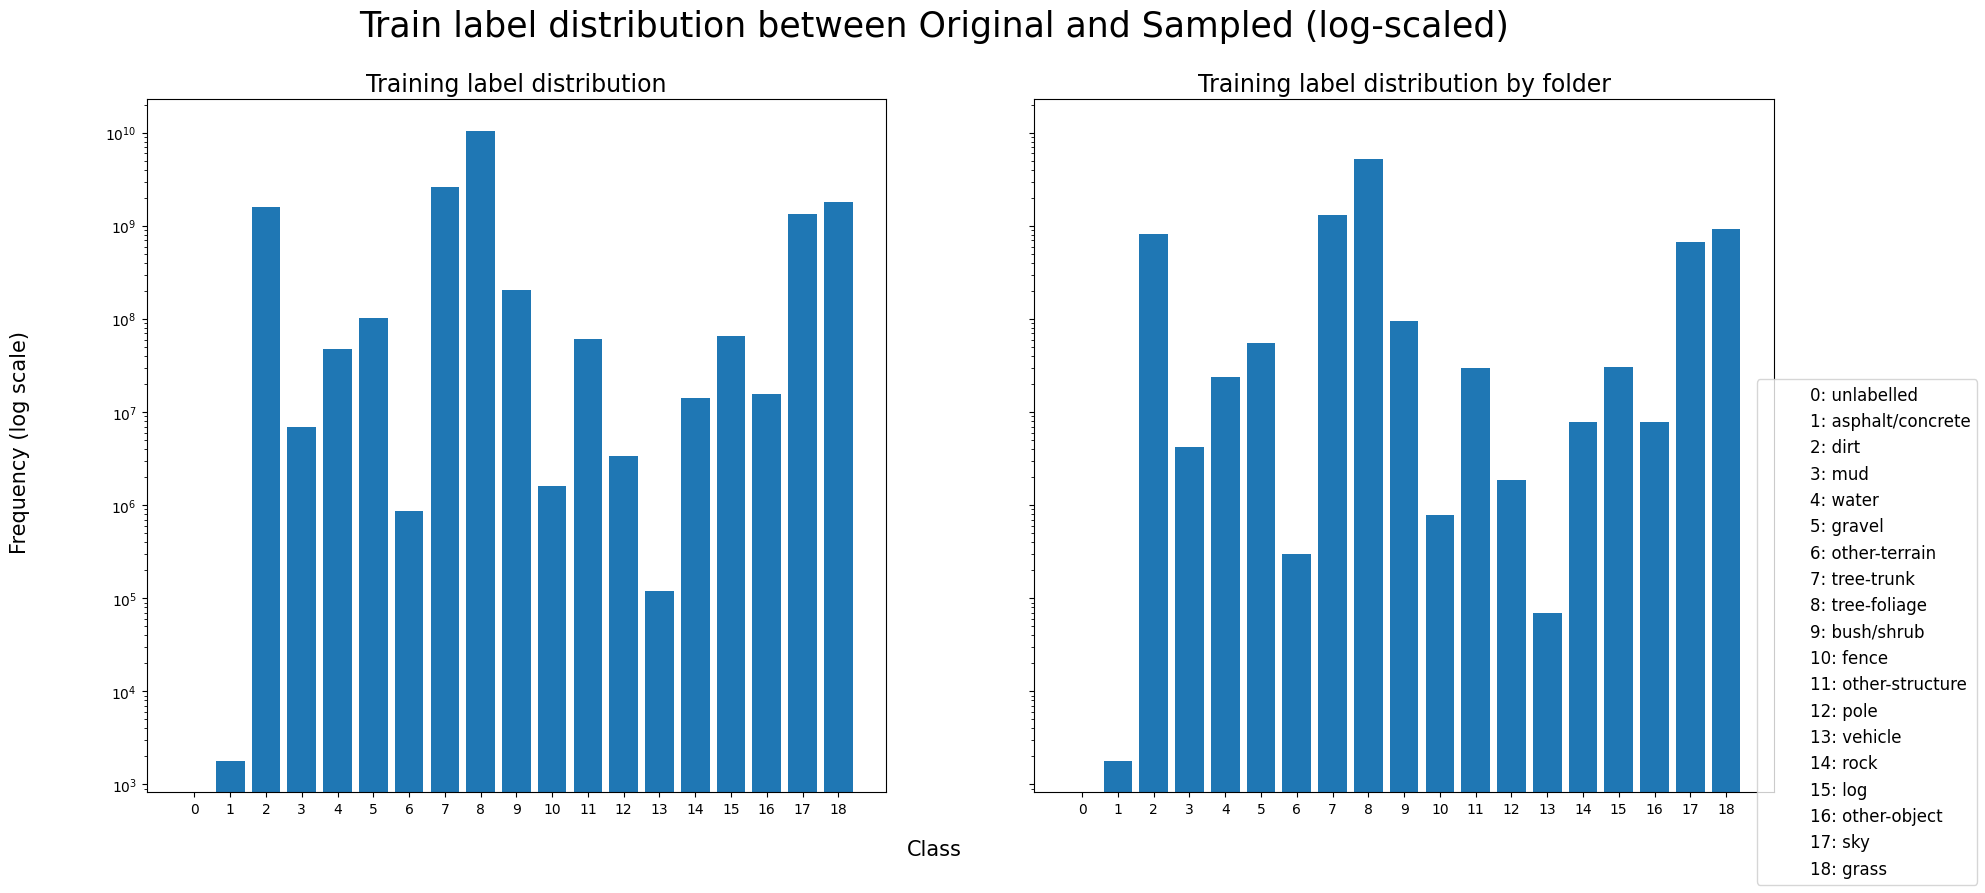

In [323]:
plot_multiple_distributions(
    [train_labels, train_labels_sampled],
    "Train label distribution between Original and Sampled",
    subtitles=["Training label distribution", "Training label distribution by folder"],
    labels=id_labels,
    x_axis_factor=1.4,
    y_axis_factor=0.6,
    sharey=True
)

### Normal-scaled comparison

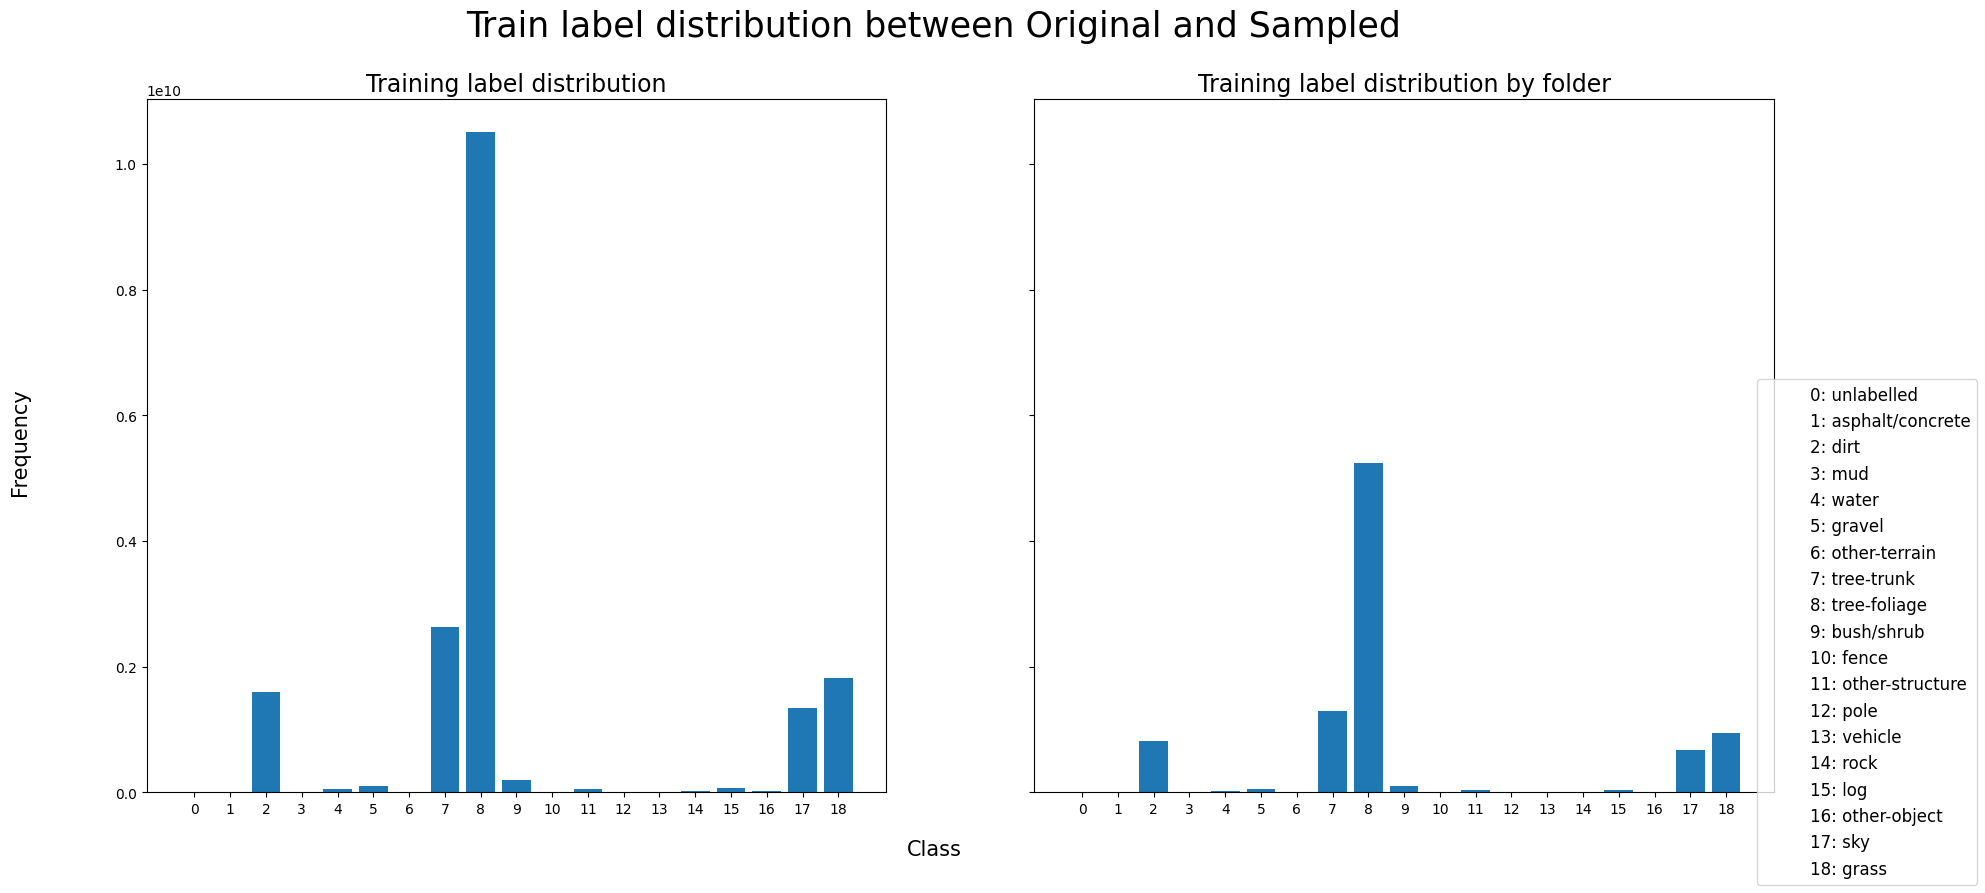

In [324]:
plot_multiple_distributions(
    [train_labels, train_labels_sampled],
    "Train label distribution between Original and Sampled",
    subtitles=["Training label distribution", "Training label distribution by folder"],
    labels=id_labels,
    x_axis_factor=1.4,
    y_axis_factor=0.6,
    log=False,
    sharey=True,
)

### **Folder Stratified Sampled Training**

In [317]:
train_sample = np.array(train_df['label_path'])[train_indx_sampled]
train_folders_sampled = filter_by_subdirectories(train_sample, subdirectories)
train_folder_labels_sampled = get_folder_labels(train_folders_sampled)

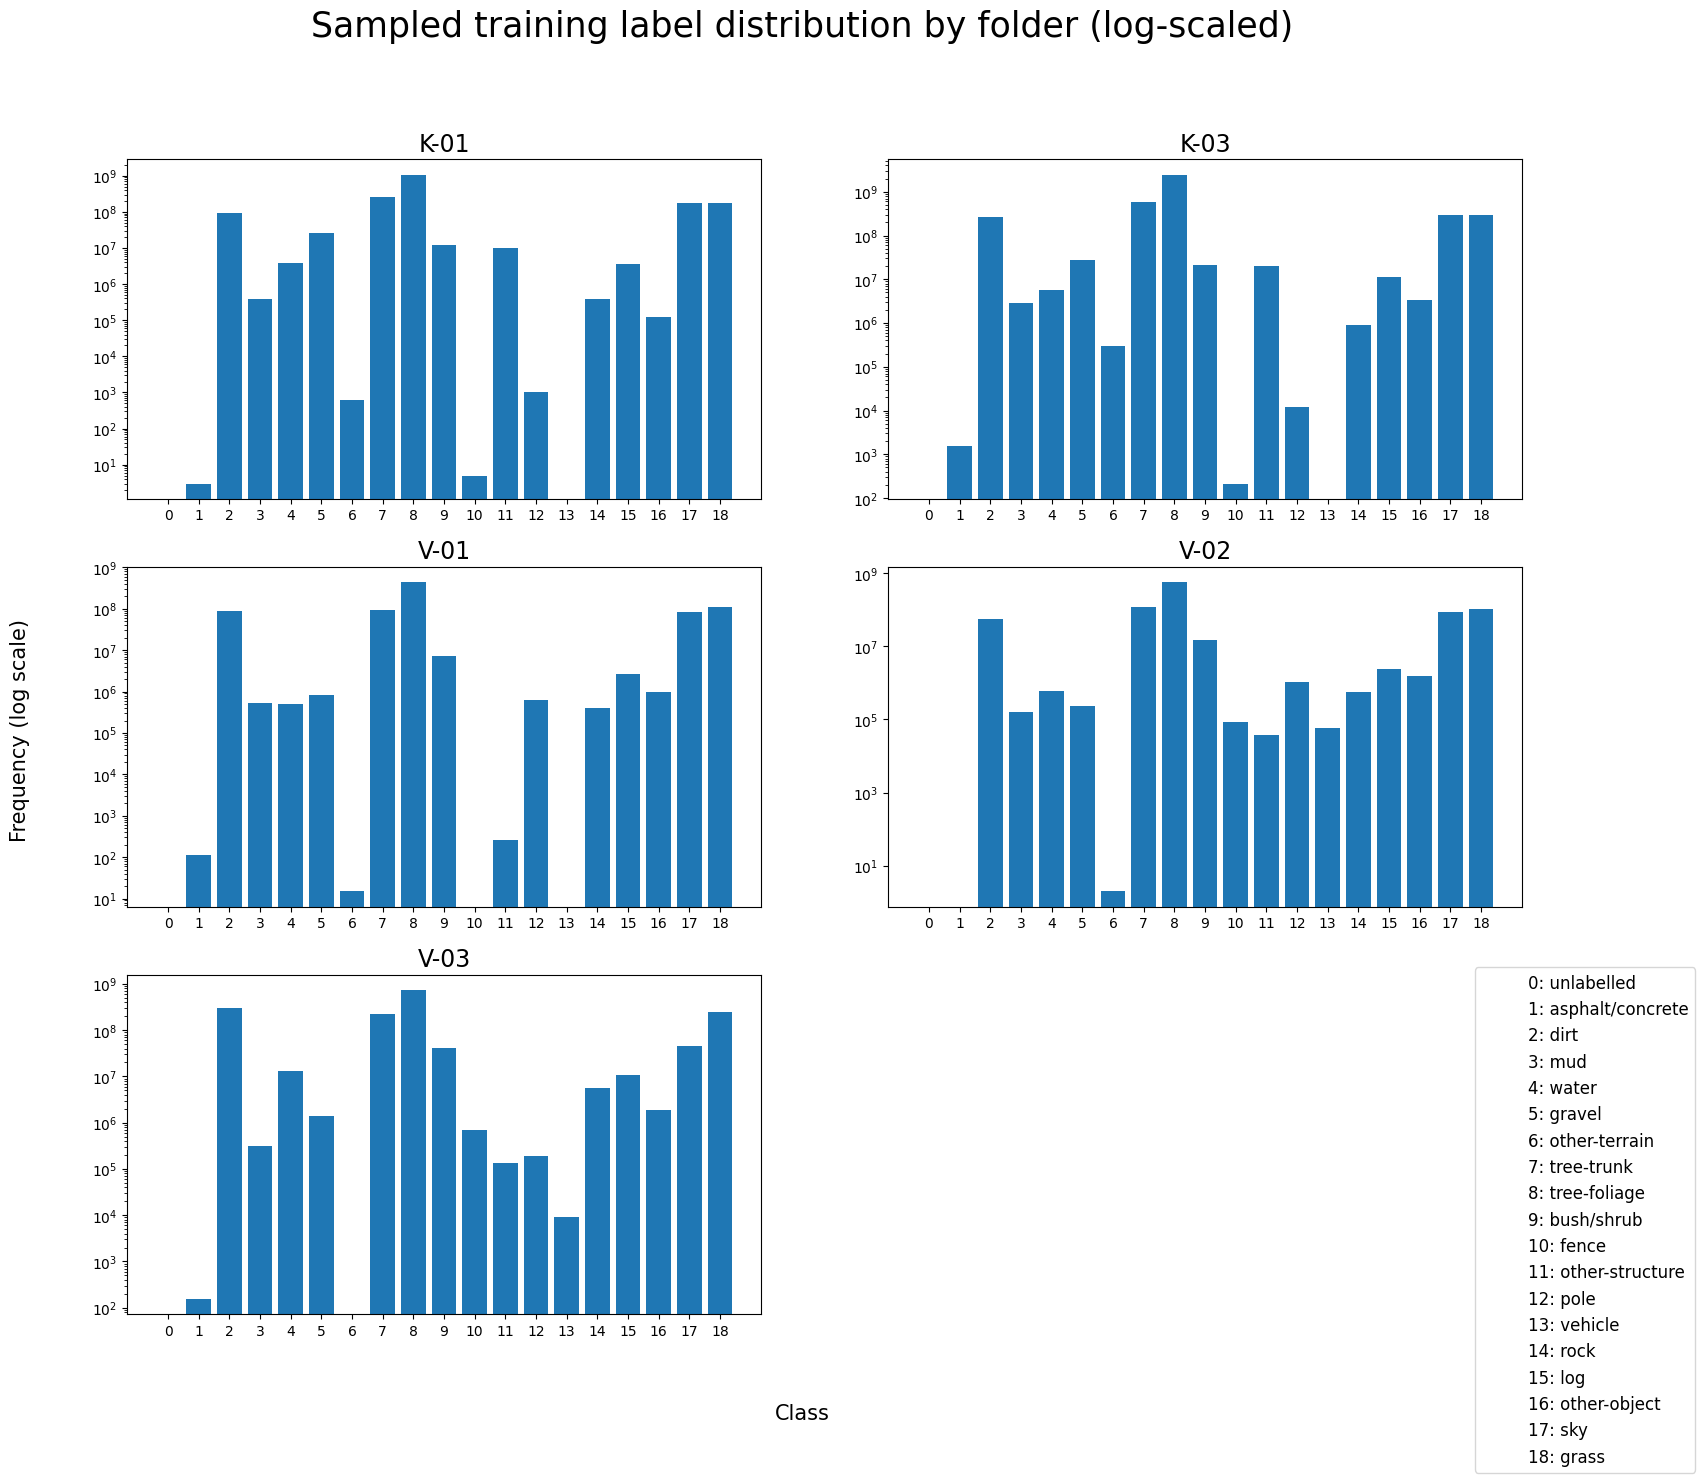

In [318]:
plot_multiple_distributions(
    train_folder_labels_sampled,
    "Sampled training label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    x_axis_factor=1.2,
)

### Saving sample csv

In [455]:
train_sample_df = train_df.iloc[train_indx_sampled]
train_sample_df.to_csv('train_sample.csv', index=False)

train_sample_df2 = train_df.iloc[train_indx_sampled2]
train_sample_df2.to_csv('train_sample2.csv', index=False)

In [ ]:
# pip install scikit-multilearn --quiet

In [325]:
# from skmultilearn.model_selection import IterativeStratification
# k_fold = IterativeStratification(n_splits=2, order=1)

# from skmultilearn.model_selection import iterative_train_test_split

# X = np.array(train_df['label_path'])
# splits = k_fold.split(X, y_train)
# X_t, y_t, X_, y_ = iterative_train_test_split(X, y_train, test_size=0.5)


# train_labels_sampled = get_labels_sampled(train_df)
# print_sampling_info(train_labels, train_labels_sampled, "train", id_labels)